In [42]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import PurePosixPath, PureWindowsPath

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = int(self.annotations.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, return_label=0.5, transform=None):
        self.images = [file.name for file in os.scandir(img_dir)]
        self.img_dir = str(img_dir)
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.return_label

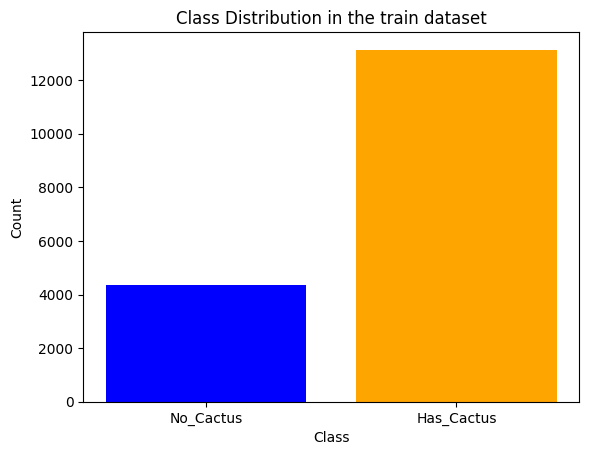

In [44]:


count_0 = 4364  # -> 12000/13000
count_1 = 13136

plt.bar(['No_Cactus', 'Has_Cactus'], [count_0, count_1], color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in the train dataset')
plt.show()

In [45]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

csv_file = PurePosixPath("data/train.csv")
if os.name == 'nt':
    csv_file = PureWindowsPath(csv_file)

train_dir = PurePosixPath("data/train/train")
if os.name == 'nt':
    train_dir = PureWindowsPath(train_dir)

augmented_folder = PurePosixPath("data/train/train_augmented")
if os.name == 'nt':
    augmented_folder = PureWindowsPath(augmented_folder)

test_dir = PurePosixPath("data/test/test")
if os.name == 'nt':
    test_dir = PureWindowsPath(test_dir)

In [46]:
# Da eseguire solo una volta per generare le immagini augmentate


# train_dataset = CustomImageDataset(
#     csv_file=csv_file,
#     img_dir=train_dir,
#     transform=transform
# )

# dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# print(len(dataloader))

# # Augmentations to apply
# augment = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(np.random.uniform(0, 45)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
# ])

# output_dir = "data\\train\\train_augmented"
# os.makedirs(output_dir, exist_ok=True)

# # How many new versions of each image to generate?
# num_augmented = 2

# i = 0
# for images, labels in tqdm(dataloader):
#     for (image, label) in zip(images, labels):
#         if label == 0:
#             for j in range(num_augmented):
#                 aug_img = augment(image)
#                 new_filename = f"aug_{i}_{j}.jpg"
#                 aug_img.save(os.path.join(output_dir, new_filename))
#         i+=1

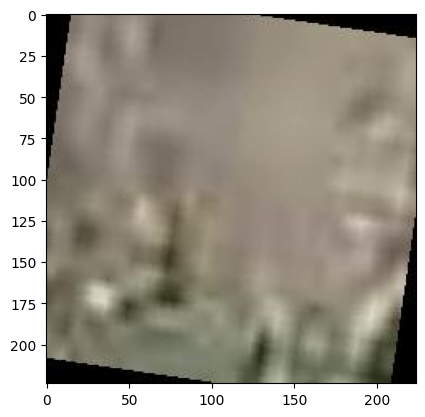

In [ ]:
train_dataset = CustomImageDataset(
    csv_file=csv_file,
    img_dir=train_dir,
    transform=transform
)

augmented_dataset = UnlabeledImageDataset(
    img_dir=augmented_folder,
    return_label=0,
    transform=transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
)

training_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)


for (i, (images, labels)) in enumerate(training_dataloader):
    for (img, label) in zip(images, labels):
        if label == 0:
            plt.imshow(img.permute(1, 2, 0))
            break
    break

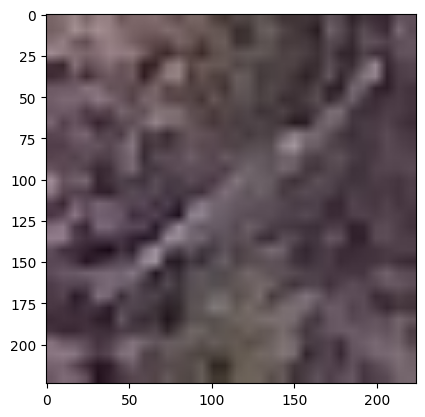

In [49]:
test_dataset = UnlabeledImageDataset(
    img_dir=test_dir,
    transform=transform
)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for (i, (images, labels)) in enumerate(test_dataloader):
    for (img, label) in zip(images, labels):
        plt.imshow(img.permute(1, 2, 0))
        break
    break